# Learning Points

Today you've learned

* How to use histograms to visualise distributions

* How to superimpose histograms on top of each other even when the data series have different lengths

* How to use a to smooth out kinks in a histogram and visualise a distribution with a Kernel Density Estimate (KDE)

* How to improve a KDE by specifying boundaries on the estimates

* How to use scipy and test for statistical significance by looking at p-values.

* How to highlight different parts of a time series chart in Matplotib.

* How to add and configure a Legend in Matplotlib.

* Use NumPy's `.where()` function to process elements depending on a condition.

# Setup and Context

<img src="https://i.imgur.com/gugIA5r.png" width=700>

### Introduction

Dr Ignaz Semmelweis was a Hungarian physician born in 1818 who worked in the Vienna General Hospital. In the past people thought of illness as caused by "bad air" or evil spirits. But in the 1800s Doctors started looking more at anatomy, doing autopsies and started making arguments based on data. Dr Semmelweis suspected that something was going wrong with the procedures at Vienna General Hospital. Semmelweis wanted to figure out why so many women in maternity wards were dying from childbed fever (i.e., [puerperal fever](https://en.wikipedia.org/wiki/Postpartum_infections)).

<img src=https://i.imgur.com/lSyNUwR.png width=700>

Today you will become Dr Semmelweis. This is your office 👆. You will step into Dr Semmelweis' shoes and analyse the same data collected from 1841 to 1849.

### The Data Source

Dr Semmelweis published his research in 1861. I found the scanned pages of the [full text with the original tables in German](http://www.deutschestextarchiv.de/book/show/semmelweis_kindbettfieber_1861), but an excellent [English translation can be found here](http://graphics8.nytimes.com/images/blogs/freakonomics/pdf/the%20etiology,%20concept%20and%20prophylaxis%20of%20childbed%20fever.pdf).

<img src=https://i.imgur.com/6HfLtaC.png width=500>

### Upgrade plotly (only Google Colab Notebook)

Google Colab may not be running the latest version of plotly. If you're working in Google Colab, uncomment the line below, run the cell, and restart your notebook server. 

In [1]:
# %pip install --upgrade plotly

### Import Statements

In [72]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats

### Notebook Presentation

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

# Create locators for ticks on the time axis


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### Read the Data

In [4]:
df_yearly = pd.read_csv('annual_deaths_by_clinic.csv')
# parse_dates avoids DateTime conversion later
df_monthly = pd.read_csv('monthly_deaths.csv', 
                      parse_dates=['date'])

# Preliminary Data Exploration

**Challenge**: Check out these two DataFrames ☝️. 
* What is the shape of df_yearly and df_monthly? How many rows and columns?
* What are the column names?
* Which years are included in the dataset?
* Are there any NaN values or duplicates?
* What were the average number of births that took place per month?
* What were the average number of deaths that took place per month?

In [5]:
print(f"Yearly data rows and cols: {df_yearly.shape}")
print(f"Monthly data rows and cols: {df_monthly.shape}")

Yearly data rows and cols: (12, 4)
Monthly data rows and cols: (98, 3)


In [6]:
df_yearly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    12 non-null     int64 
 1   births  12 non-null     int64 
 2   deaths  12 non-null     int64 
 3   clinic  12 non-null     object
dtypes: int64(3), object(1)
memory usage: 512.0+ bytes


In [7]:
df_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    98 non-null     datetime64[ns]
 1   births  98 non-null     int64         
 2   deaths  98 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.4 KB


In [8]:
print(f'Monthly data min date: {df_monthly["date"].min().date()} and max date: {df_monthly["date"].max().date()}')
print(f'yearly data min year: {df_yearly["year"].min()} and max year: {df_yearly["year"].max()}')

Monthly data min date: 1841-01-01 and max date: 1849-03-01
yearly data min year: 1841 and max year: 1846


### Check for Nan Values and Duplicates

In [9]:
# Checking for duplicates
df_monthly[df_monthly.duplicated()]

,date,births,deaths


In [10]:
df_yearly[df_yearly.duplicated()]

,year,births,deaths,clinic


In [11]:
# Confirming no nulls
df_monthly.isna().values.any()

False

In [12]:
df_yearly.isna().values.any()

False

In [13]:
# Avg births per month
avg_events = df_monthly.groupby('date').agg(
    avg_births=('births', 'mean'),
    avg_deaths=('deaths', 'mean')).\
    reset_index()
avg_events

,date,avg_births,avg_deaths
0,1841-01-01,254.00,37.00
1,1841-02-01,239.00,18.00
2,1841-03-01,277.00,12.00
3,1841-04-01,255.00,4.00
4,1841-05-01,255.00,2.00
...,...,...,...
93,1848-11-01,310.00,9.00
94,1848-12-01,373.00,5.00
95,1849-01-01,403.00,9.00
96,1849-02-01,389.00,12.00


### Descriptive Statistics

In [14]:
df_monthly.describe()

,births,deaths
count,98.00,98.00
mean,267.00,22.47
std,41.77,18.14
min,190.00,0.00
25%,242.50,8.00
50%,264.00,16.50
75%,292.75,36.75
max,406.00,75.00


In [15]:
df_yearly.describe()

,year,births,deaths
count,12.00,12.00,12.00
mean,"1,843.50","3,152.75",223.33
std,1.78,449.08,145.38
min,"1,841.00","2,442.00",66.00
25%,"1,842.00","2,901.75",100.25
50%,"1,843.50","3,108.50",219.50
75%,"1,845.00","3,338.25",263.50
max,"1,846.00","4,010.00",518.00


### Percentage of Women Dying in Childbirth

**Challenge**: How dangerous was childbirth in the 1840s in Vienna? 

* Using the annual data, calculate the percentage of women giving birth who died throughout the 1840s at the hospital.


In comparison, the United States recorded 18.5 maternal deaths per 100,000 or 0.018% in 2013 [(source).](
https://en.wikipedia.org/wiki/Maternal_death#:~:text=The%20US%20has%20the%20%22highest,17.8%20per%20100%2C000%20in%202009)

In [16]:
'{:.3%}'.format(sum(df_yearly['deaths']) / sum(df_yearly['births']))

'7.084%'

# Visualise the Total Number of Births 🤱 and Deaths 💀 over Time

### Plot the Monthly Data on Twin Axes

**Challenge**: Create a [Matplotlib chart](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.plot.html) with twin y-axes. It should look something like this:

<img src=https://i.imgur.com/F9DOJxx.png width=700>

* Format the x-axis using locators for the years and months (Hint: we did this in the Google Trends notebook)
* Set the range on the x-axis so that the chart lines touch the y-axes
* Add gridlines
* Use `skyblue` and `crimson` for the line colours
* Use a dashed line style for the number of deaths
* Change the line thickness to 3 and 2 for the births and deaths respectively. 
* Do you notice anything in the late 1840s?

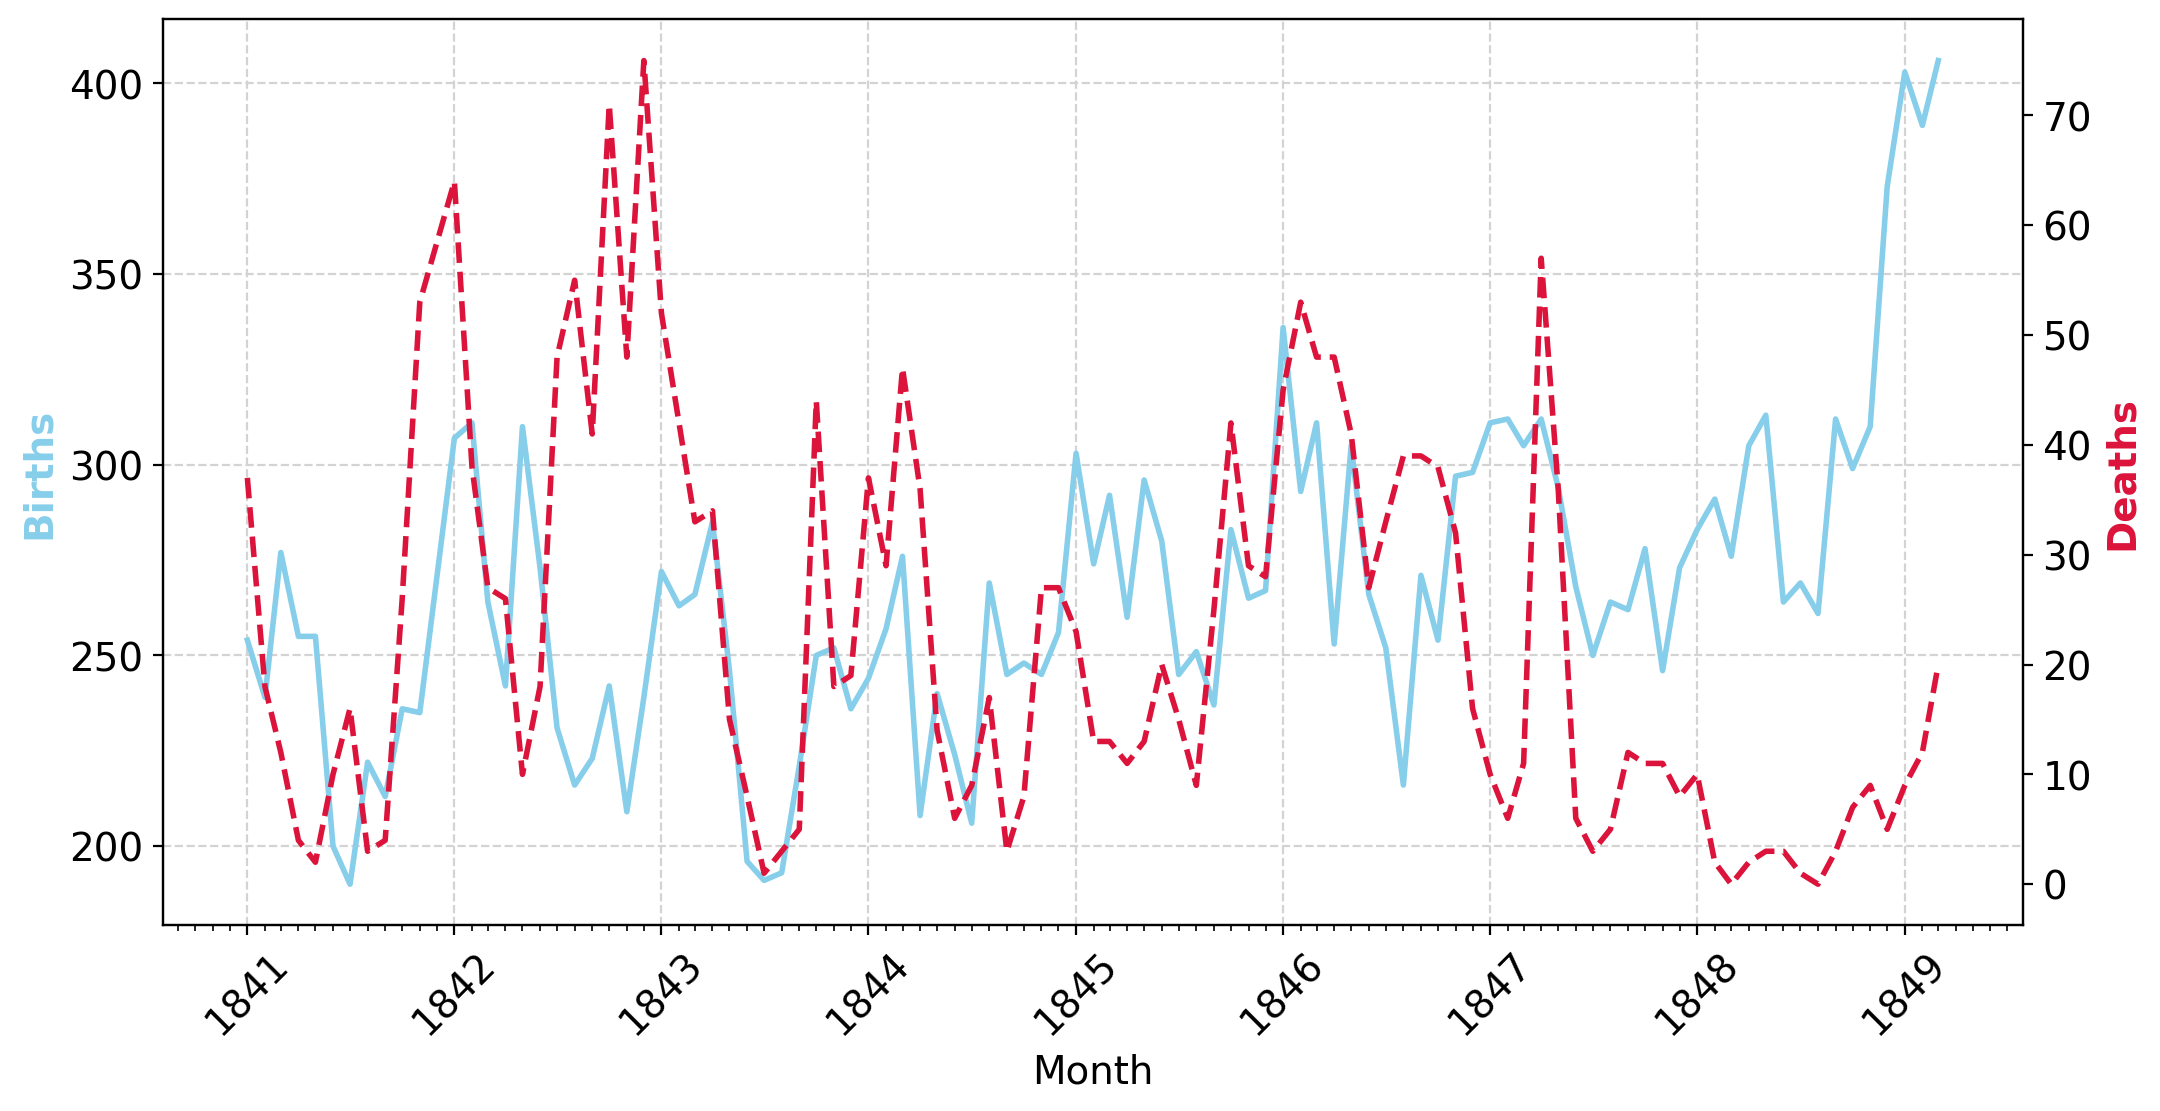

In [17]:
# Create locators for ticks on the time axis
years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

fig = plt.figure(figsize=(12,6), dpi=200)

ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(df_monthly['date'], df_monthly['births'], color='skyblue', linewidth=2)
ax2.plot(df_monthly['date'], df_monthly['deaths'], color='crimson', linewidth=2, linestyle='dashed')

ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Births', color='skyblue', fontweight='bold', fontsize=14)
ax2.set_ylabel('Deaths', color='crimson', fontweight='bold', fontsize=14)

ax1.tick_params(axis='x', labelsize=14, rotation=45)
ax1.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax1.grid(b=True, which='major', axis='both', color='LightGrey', linestyle='dashed')

ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(years_fmt)
ax1.xaxis.set_minor_locator(months)

plt.show()

# The Yearly Data Split by Clinic

Now let's look at the annual data instead. 

**Challenge**: Use plotly to create line charts of the births and deaths of the two different clinics at the Vienna General Hospital. 
* Which clinic is bigger or more busy judging by the number of births?
* Has the hospital had more patients over time? 
* What was the highest number of deaths recorded in clinic 1 and clinic 2?

In [18]:
fig = px.line(df_yearly, x='year', y='births', color='clinic',
              title="Births per Year by Clinic")
fig.show()

In [19]:
fig = px.line(df_yearly, x='year', y='deaths', color='clinic',
              title="Deaths per Year by Clinic")
fig.show()

### Calculate the Proportion of Deaths at Each Clinic

**Challenge**: Calculate the proportion of maternal deaths per clinic. That way we can compare like with like. 
* Work out the percentage of deaths for each row in the `df_yearly` DataFrame by adding a column called "pct_deaths". 
* Calculate the average maternal death rate for clinic 1 and clinic 2 (i.e., the total number of deaths per the total number of births).
* Create another plotly line chart to see how the percentage varies year over year with the two different clinics.
* Which clinic has a higher proportion of deaths?
* What is the highest monthly death rate in clinic 1 compared to clinic 2?

In [20]:
df_yearly['pct_deaths'] = df_yearly['deaths'] / df_yearly['births']
# Maternal mortality rate by clinic
df_yearly.groupby('clinic')['deaths'].sum() / df_yearly.groupby('clinic')['births'].sum()

clinic
clinic 1   0.10
clinic 2   0.04
dtype: float64

### Plotting the Proportion of Yearly Deaths by Clinic

In [21]:
fig = px.line(df_yearly, x='year', y='pct_deaths', color='clinic',
              title='Maternal Mortality Rate by Clinic')
fig.show()

# The Effect of Handwashing

Dr Semmelweis made handwashing obligatory in the summer of 1947. In fact, he ordered people to wash their hands with chlorine (instead of water).

In [22]:
# Date when handwashing was made mandatory
handwashing_start = pd.to_datetime('1847-06-01')

**Challenge**: 
* Add a column called "pct_deaths" to `df_monthly` that has the percentage of deaths per birth for each row. 
* Create two subsets from the `df_monthly` data: before and after Dr Semmelweis ordered washing hands.
* Calculate the average death rate prior to June 1947.
* Calculate the average death rate after June 1947.

In [23]:
df_monthly['pct_deaths'] = df_monthly['deaths'] / df_monthly['births']
df_monthly

,date,births,deaths,pct_deaths
0,1841-01-01,254,37,0.15
1,1841-02-01,239,18,0.08
2,1841-03-01,277,12,0.04
3,1841-04-01,255,4,0.02
4,1841-05-01,255,2,0.01
...,...,...,...,...
93,1848-11-01,310,9,0.03
94,1848-12-01,373,5,0.01
95,1849-01-01,403,9,0.02
96,1849-02-01,389,12,0.03


In [24]:
# Create binary variable for handwashing rule
df_monthly['handwash_rule_flag'] = (df_monthly['date'] >= handwashing_start).astype(int)
df_monthly

,date,births,deaths,pct_deaths,handwash_rule_flag
0,1841-01-01,254,37,0.15,0
1,1841-02-01,239,18,0.08,0
2,1841-03-01,277,12,0.04,0
3,1841-04-01,255,4,0.02,0
4,1841-05-01,255,2,0.01,0
...,...,...,...,...,...
93,1848-11-01,310,9,0.03,1
94,1848-12-01,373,5,0.01,1
95,1849-01-01,403,9,0.02,1
96,1849-02-01,389,12,0.03,1


In [25]:
df_monthly.groupby('handwash_rule_flag')['deaths'].sum() / df_monthly.groupby('handwash_rule_flag')['births'].sum()

handwash_rule_flag
0   0.11
1   0.02
dtype: float64

### Calculate a Rolling Average of the Death Rate

**Challenge**: Create a DataFrame that has the 6 month rolling average death rate prior to mandatory handwashing.

*Hint*: You'll need to set the dates as the index in order to avoid the date column being dropped during the calculation.

In [26]:
roll_df = df_monthly[df_monthly['handwash_rule_flag'] == 0].set_index('date')['deaths'].rolling(window=6).mean().reset_index()
roll_df


,date,deaths
0,1841-01-01,NaN
1,1841-02-01,NaN
2,1841-03-01,NaN
3,1841-04-01,NaN
4,1841-05-01,NaN
...,...,...
71,1847-01-01,29.00
72,1847-02-01,23.50
73,1847-03-01,18.83
74,1847-04-01,22.00


### Highlighting Subsections of a Line Chart

**Challenge**: Copy-paste and then modify the Matplotlib chart from before to plot the monthly death rates (instead of the total number of births and deaths). The chart should look something like this:

<img src=https://i.imgur.com/X6TQe0R.png width=500>

* Add 3 seperate lines to the plot: the death rate before handwashing, after handwashing, and the 6-month moving average before handwashing.
* Show the monthly death rate before handwashing as a thin dashed black line. 
* Show the moving average as a thicker, crimson line.
* Show the rate after handwashing as a skyblue line with round markers. 
* Look at the [code snippet in the documentation to see how you can add a legend](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html) to the chart.

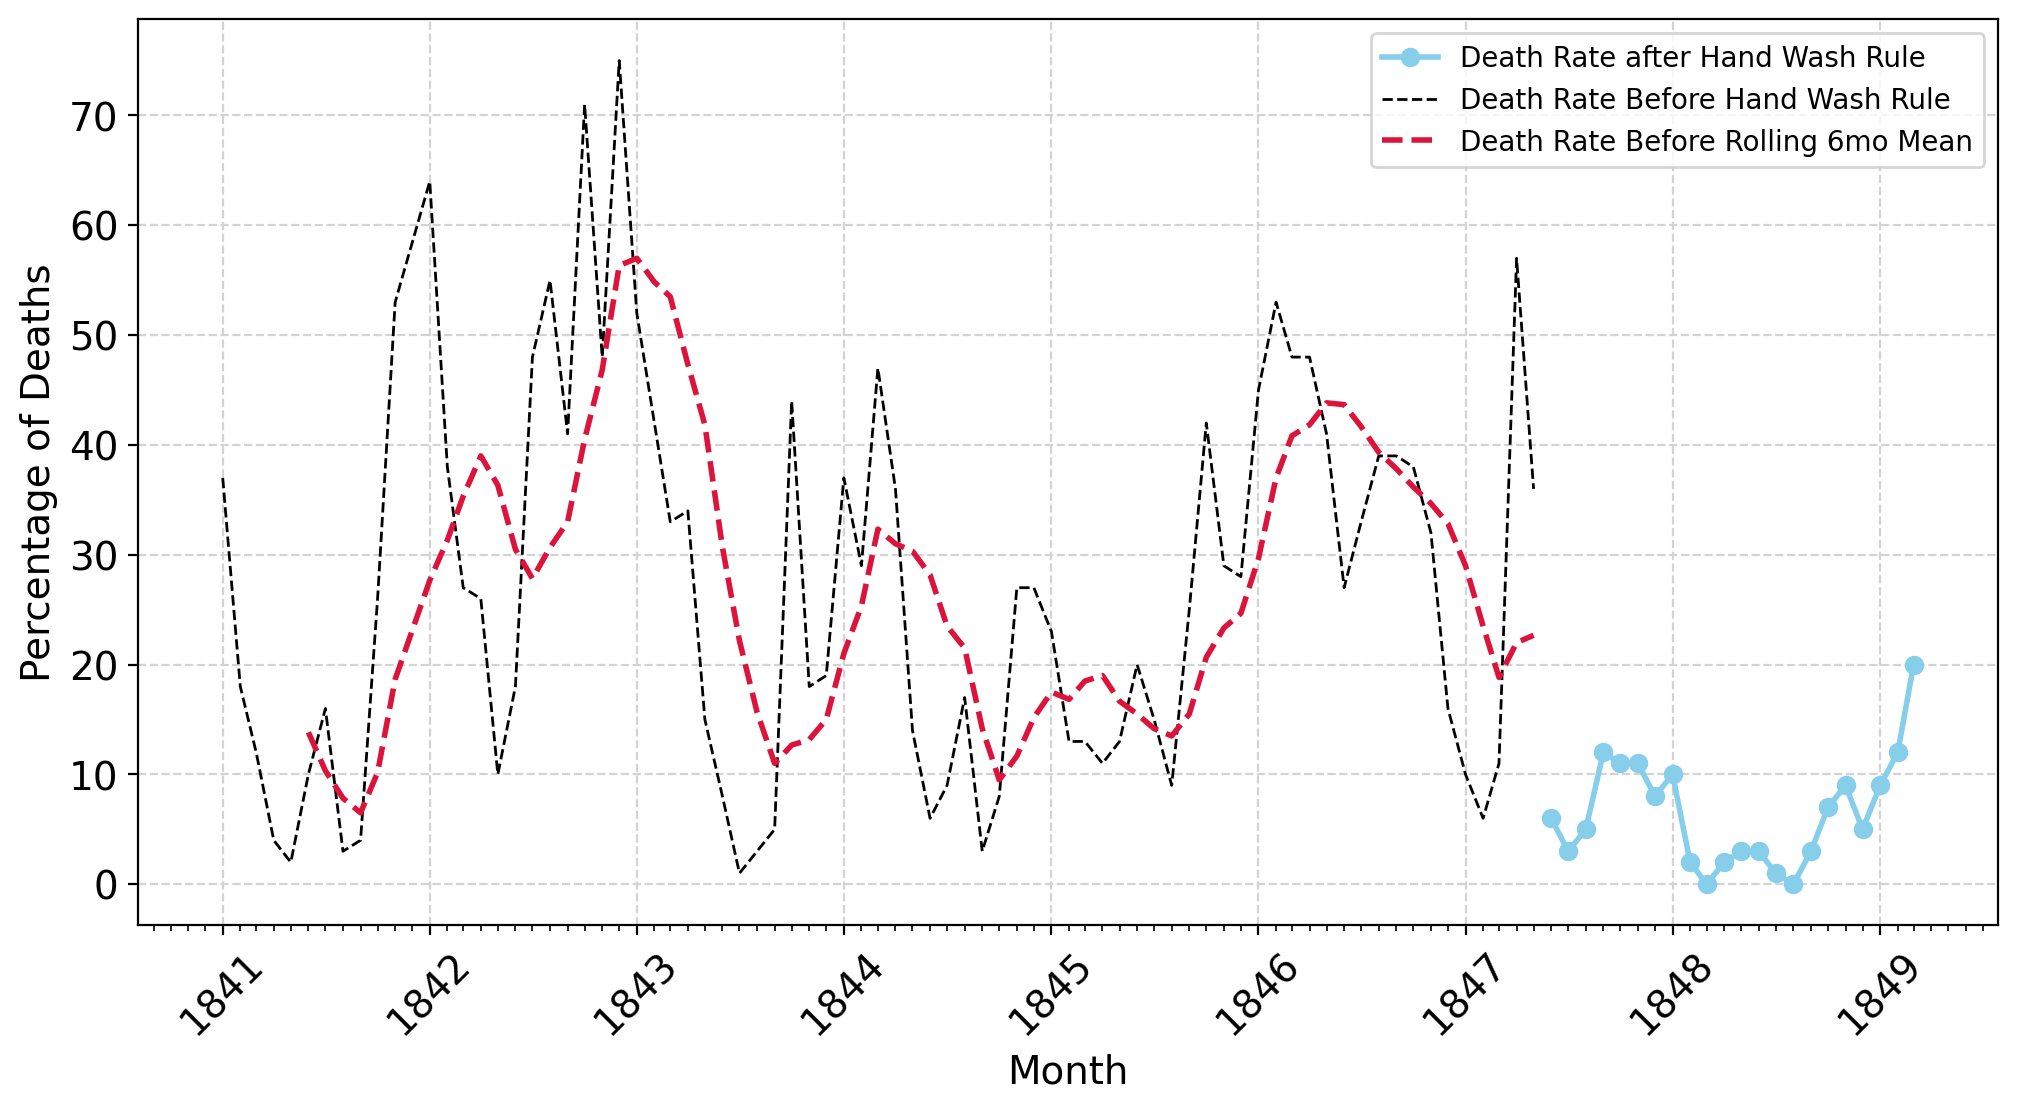

In [27]:
fig = plt.figure(figsize=(12,6), dpi=200)

ax = plt.gca()

plt.plot(df_monthly[df_monthly['handwash_rule_flag'] == 1]['date'], 
         df_monthly[df_monthly['handwash_rule_flag'] == 1]['deaths'], 
         color='skyblue', linewidth=2, marker='o',
         label='Death Rate after Hand Wash Rule')
plt.plot(df_monthly[df_monthly['handwash_rule_flag'] == 0]['date'], 
         df_monthly[df_monthly['handwash_rule_flag'] == 0]['deaths'], 
         color='black', linewidth=1, linestyle='dashed',
         label='Death Rate Before Hand Wash Rule')
plt.plot(roll_df['date'], 
         roll_df['deaths'], 
         color='crimson', linewidth=2, linestyle='dashed',
         label='Death Rate Before Rolling 6mo Mean')

ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Percentage of Deaths', fontsize=14)

ax.tick_params(axis='x', labelsize=14, rotation=45)
ax.tick_params(axis='y', labelsize=14)
ax.grid(b=True, which='major', axis='both', color='LightGrey', linestyle='dashed')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.legend()

plt.show()

### Statistics - Calculate the Difference in the Average Monthly Death Rate

**Challenge**:
* What was the average percentage of monthly deaths before handwashing? 
* What was the average percentage of monthly deaths after handwashing was made obligatory?
* By how much did handwashing reduce the average chance of dying in childbirth in percentage terms?
* How do these numbers compare to the average for all the 1840s that we calculated earlier? 
* How many times lower are the chances of dying after handwashing compared to before?

In [39]:
before_after_rates = df_monthly.groupby('handwash_rule_flag')['deaths'].sum() / df_monthly.groupby('handwash_rule_flag')['births'].sum()
f"Before hand washing the death rate was {'{:.1%}'.format(before_after_rates[0])}. After it was {'{:.1%}'.format(before_after_rates[1])}"

'Before hand washing the death rate was 10.5%. After it was 2.2%'

In [41]:
# Difference from before to after
f"That's a " + '{:.2%}'.format(before_after_rates[0] - before_after_rates[1]) + f' improvement!'

"That's a 8.37% improvement!"

In [43]:
print(f'Or, an improvement of {round(before_after_rates[0] / before_after_rates[1])}x.')

Or, an improvement of 5x.


### Use Box Plots to Show How the Death Rate Changed Before and After Handwashing

**Challenge**: 
* Use [NumPy's `.where()` function](https://numpy.org/doc/stable/reference/generated/numpy.where.html) to add a column to `df_monthly` that shows if a particular date was before or after the start of handwashing. 
* Then use plotly to create box plot of the data before and after handwashing. 
* How did key statistics like the mean, max, min, 1st and 3rd quartile changed as a result of the new policy?



In [46]:
fig = px.box(df_monthly, y='deaths', color='handwash_rule_flag')
fig.show()

### Use Histograms to Visualise the Monthly Distribution of Outcomes

**Challenge**: Create a [plotly histogram](https://plotly.com/python/histograms/) to show the monthly percentage of deaths. 

* Use docs to check out the available parameters. Use the [`color` parameter](https://plotly.github.io/plotly.py-docs/generated/plotly.express.histogram.html) to display two overlapping histograms.
* The time period of handwashing is shorter than not handwashing. Change `histnorm` to `percent` to make the time periods comparable. 
* Make the histograms slightly transparent
* Experiment with the number of bins on the histogram. Which number work well in communicating the range of outcomes?
* Just for fun, display your box plot on the top of the histogram using the `marginal` parameter. 

In [58]:
fig = px.histogram(df_monthly, x='pct_deaths', color='handwash_rule_flag',
                   opacity=0.6, nbins=20, barmode='overlay', marginal='box')
fig.show()

### Use a Kernel Density Estimate (KDE) to visualise a smooth distribution

**Challenge**: Use [Seaborn's `.kdeplot()`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) to create two kernel density estimates of the `pct_deaths`, one for before handwashing and one for after. 

* Use the `shade` parameter to give your two distributions different colours. 
* What weakness in the chart do you see when you just use the default parameters?
* Use the `clip` parameter to address the problem. 


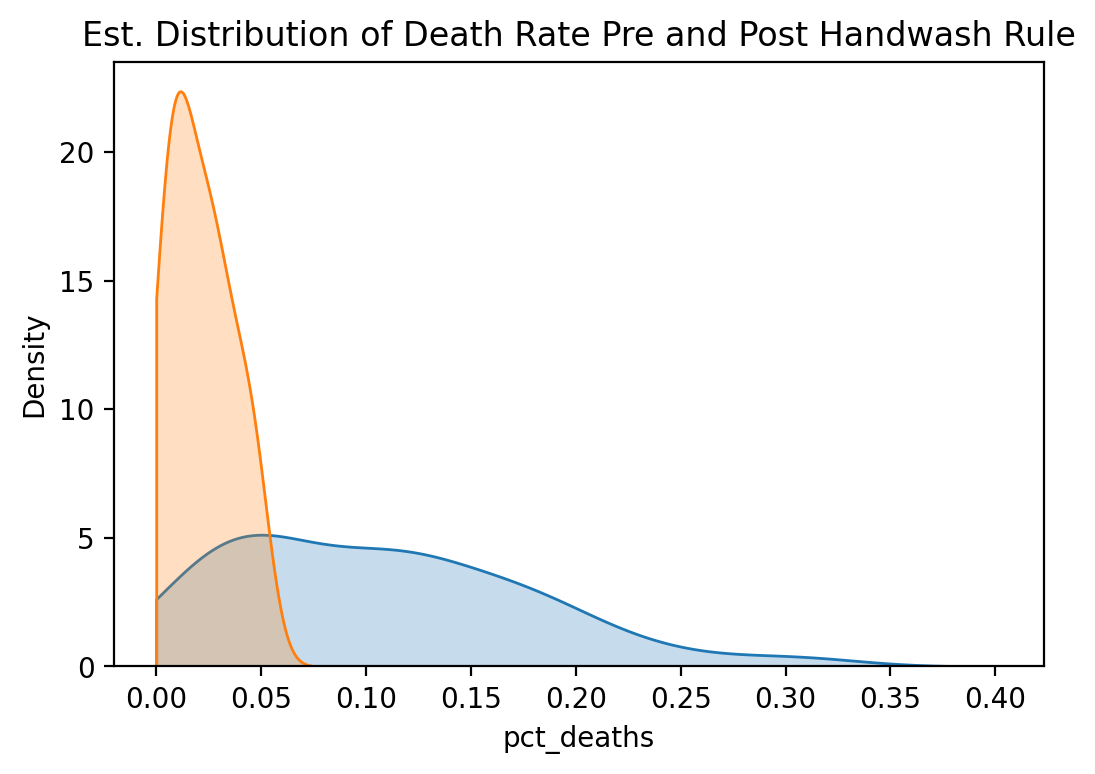

In [71]:
plt.figure(dpi=200)
sns.kdeplot(x=df_monthly[df_monthly['handwash_rule_flag'] == 0]['pct_deaths'], fill=True, clip=(0.0, 1))
sns.kdeplot(x=df_monthly[df_monthly['handwash_rule_flag'] == 1]['pct_deaths'], fill=True, clip=(0.0, 1))
plt.title('Est. Distribution of Death Rate Pre and Post Handwash Rule')
plt.show()

### Use a T-Test to Show Statistical Significance

**Challenge**: Use a t-test to determine if the differences in the means are statistically significant or purely due to chance. 

If the p-value is less than 1% then we can be 99% certain that handwashing has made a difference to the average monthly death rate. 

* Import `stats` from scipy
* Use the [`.ttest_ind()` function](https://docs.scipy.org/]doc/scipy/reference/generated/scipy.stats.ttest_ind.html) to calculate the t-statistic and the p-value
* Is the difference in the average proportion of monthly deaths statistically significant at the 99% level? 



In [77]:
stats.ttest_ind(a=df_monthly[df_monthly['handwash_rule_flag'] == 0]['pct_deaths'], b=df_monthly[df_monthly['handwash_rule_flag'] == 1]['pct_deaths'])

Ttest_indResult(statistic=5.511607211341916, pvalue=2.985436556724523e-07)

What do you conclude from your analysis, Doctor? 😊

<img src=https://i.imgur.com/rvjNVzQ.gif>